# Тема 32. Презентации результатов проекта по распознаванию типа одежды по фотографии на Keras

Использованы [материалы](https://keras.io/examples/vision/mnist_convnet/) документации [Keras](https://keras.io/):

**Author:** [fchollet](https://twitter.com/fchollet)<br>


# Задание
В этом задании вы должны создать и обучить нейронную сеть отличать типы одежды по их изображениям. Используйте все знания предыдущих уроков. Требуется получить не менее 80% правильных распознаваний (accuracy по тестовым данным). Пробуйте разные слои, их параметры, но нельзя заменять данные на другие.

Разбейтесь на группы и попробуйте победить соперника по точности accuracy. Представьте ваши решения, сравните с базовым. Объясните почему вы выбрали именно такую структуру нейронной сети.

Для корректности давайте ограничимся максимум 5 эпохами (учитель может назвать другое число), функция ошибки - кроссэнтропия, метрика - accuracy, нельзя менять данные.

Все остальное: слои в сети, их параметры, методы обучения и их параметры, можете менять по своему усмотрению.

Вперед к победе!

## Подключение
Сначала подключим все необходимые библиотеки, numpy, keras из tensorflow и слои layers из него. Не пугайтесь предупреждений Warning, они ничего не испортят.

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

## Загрузка и подготовка данных
Сначала нужно загрузить и подготовить все необходимые данные. Мы уже нашли подходящие - примеры изображений предметов одежды, 10 категорий, серые, размером (28, 28, 1). Загрузим их командой `keras.datasets.fashion_mnist.load_data()` 

In [2]:
# Гиперпараметры модели
num_classes = 10 # число классов - 
input_shape = (28, 28, 1) # размер изображений, они не цветные, поэтому канал 1.

# загружаем данные (изображения и их классы), отдельно обучающие и тестовые
(x_train, y_train_cat), (x_test, y_test_cat) = keras.datasets.fashion_mnist.load_data()
 #

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
# это массивы numpy, посмотрите их размеры
print(x_train.shape)
print(y_train_cat.shape)

(60000, 28, 28)
(60000,)


Изображения - массивы целых чисел от 0 до 255, для обучения их нужно перевести в числа с плавающей точкой (float) в диапазон [0 , 1]


In [4]:
# Преобразуем во float и диапазон [0, 1]
x_train = x_train.astype("float32") / 255 #
x_test = x_test.astype("float32") / 255 #
# на всякий случай принудительно сделаем размер (28, 28, 1)
x_train = np.expand_dims(x_train, -1) # для обучающих
x_test = np.expand_dims(x_test, -1) # для тестовых
print("x_train shape:", x_train.shape) # размер массива
print(x_train.shape[0], "train samples") # число примеров обучения
print(x_test.shape[0], "test samples") # число примеров теста

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


В нашем примере 10 классов, значит надо использовать 10-мерные вектора для кодирования классов. Для этого есть вспомогательная функция `keras.utils.to_categorical`

In [5]:
# переводим метки классов в бинарные вектора 
y_train = keras.utils.to_categorical(y_train_cat, num_classes) # обучающие
y_test = keras.utils.to_categorical(y_test_cat, num_classes) # тестовые

In [6]:
print(y_train.shape) # размер массива
print(y_train[0]) # первый элемент его

(60000, 10)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


Сделаем функцию для отображения фотографии и подписи ее класса. Порядок классов предопределен при создании.

In [15]:
from matplotlib import pyplot as plt  # 
def plotMatrixWithLabel(data,label):
    cat_names=('0.Футболка','1.Брюки','2.Свитер','3.Платье','4.Пальто',
               '5.Сандаль','6.Рубашка','7.Ботинок','8.Сумка','9.Сапог')
    plt.imshow(data[:,:,0],cmap="gray")# 
    plt.title(cat_names[label])#

    

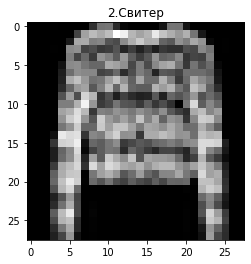

In [19]:
ind=np.random.randint(60000)# случайный пример
plotMatrixWithLabel(x_train[ind],y_train_cat[ind])# рисуем его

## Создание нейронной сети
Надо указать какие слои есть в нейронной сети и параметры этих слоев, если нужны.
Мы строим простую сеть, в которой слои будут идти последовательно, для чего используется контейнер `keras.Sequential()`. Указывайте здесь свои слои, следите за размерами выходов слоев.

In [20]:
# задаем последовательную модель
model = keras.Sequential( # слои перечисляются ниже
    [
        # слой входов (это не нейроны, а именно входы, т.е. данные), указываем размер shape
        keras.Input(shape=input_shape), 
        # первый сверточный слой, указываем число фильтров (32), размер ядра (3 на 3), функцию активации (relu)
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"), 
        # слой пулинга, не обучаемый, но позволит уменьшить размер. указываем размер ядра пулинга (2 на 2)
        layers.MaxPooling2D(pool_size=(2, 2)), #
        # второй сверточный слой, указываем число фильтров (64), размер ядра (3 на 3), функцию активации (relu)
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"), #
        # снова пулинг, после этого слоя размер массива выхода уже не большой
        layers.MaxPooling2D(pool_size=(2, 2)), #
        # слой "выпрямления", когда массив вытягивается в вектор, просто изменяет форму массива,
        # нужен чтобы массивы были подходящей размерности.
        layers.Flatten(), #
        # слой дропаута, будет при обучении случайно удалять связи, указываем вероятность удаления связи от 0 до 1 (0.5)
        layers.Dropout(0.5), #
        # полносвязный слой как в персептроне, размер его равен числу классов, функция активации softmax
        layers.Dense(num_classes, activation="softmax"), #
    ]
)

Посмотрим на созданную сеть, особенно обратите внимание на размерности массивов выхода и число обучающих параметров в слое (первый None относится к числу обучающих примеров, вход  не показан, функции активации не показаны).

In [21]:
model.summary() # информация о созданной сети

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

## Обучение сети
Сеть создана, теперь ее надо обучить. 

Необходимо указать какая используется функция ошибки, метод обучения и его параметры, метрика для проверки. 

Для задания параметров обучения используем метод `.compile()`.

Для обучения - метод `.fit()`. Здесь часть данных может быть использована для проверки (validation) работы сети, чтобы в случае если вдруг ошибка обобщения начала увеличиваться, то остановить процесс и не испортить уже достигнутой точности.

О возможных вариантах слоев, функций ошибки, методов обучения и метрик смотри [справку](https://keras.io/api/). 

In [22]:
batch_size = 128 # размер пакета (batch)
epochs = 5 # количество эпох обучения

# задаем функцию ошибки, метод обучения и метрику проверки
model.compile(
    loss="categorical_crossentropy", # кросс-энтропия, одна из возможных функций ошибки, часто используется для классификации
    optimizer="adam", # метод обучения Adam - модификация градиентного спуска
    metrics=["accuracy"]) # метрика accuracy
# запускаем обучение
model.fit(
    x_train, # входные обучающие данные
    y_train, # желаемые выходные данные (указания учителя)
    batch_size=batch_size, # размер пакета
    epochs=epochs, # максимальное число эпох обучения
    validation_split=0.1) # доля данных, отданных на проверку

Epoch 1/5
422/422 [==============================] - 44s 102ms/step - loss: 1.0100 - accuracy: 0.6347 - val_loss: 0.4282 - val_accuracy: 0.8477
Epoch 2/5
422/422 [==============================] - 43s 101ms/step - loss: 0.4579 - accuracy: 0.8367 - val_loss: 0.3748 - val_accuracy: 0.8638
Epoch 3/5
422/422 [==============================] - 43s 102ms/step - loss: 0.4047 - accuracy: 0.8545 - val_loss: 0.3503 - val_accuracy: 0.8697
Epoch 4/5
422/422 [==============================] - 43s 101ms/step - loss: 0.3748 - accuracy: 0.8639 - val_loss: 0.3265 - val_accuracy: 0.8813
Epoch 5/5
422/422 [==============================] - 43s 101ms/step - loss: 0.3533 - accuracy: 0.8731 - val_loss: 0.3174 - val_accuracy: 0.8847


## Проверка работы модели
Обучив сеть, давайте для тестовых данных, на которых мы не обучались, определим их классы и сравним с настоящими. Для этого используется метод `.evaluate()`

In [23]:
score = model.evaluate(x_test, y_test, verbose=0) # оцениваем нашу модель (verbose=0 подавляет вывод на экран)
print("Test loss:", score[0]) # функция ошибки на тестовых данных
print("Test accuracy:", score[1]) # метрика (из заданных, у нас accuracy) на тестовых данных


Test loss: 0.3292287588119507
Test accuracy: 0.8842999935150146


Все обучилось?

Давайте построим несколько картинок.

Чтобы рассчитать выход обученной сети по известному входу используем метод `.predict()`.
Он вернет нам вектор выхода. 

Если нам нужен номер класса, а не его вектор, то можно использовать метод `.predict_classes()`, но осторожно, эта функция почему-то не документирована.   

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


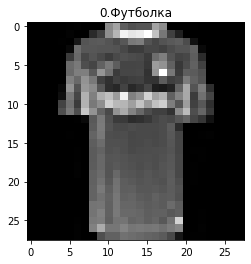

In [24]:
test_example=np.random.randint(10000)# случайный пример
# индекс примера
test_input=x_test[test_example:test_example+1] # изображение этого примера
#test_output=model.predict(test_input)#
test_output=model.predict_classes(test_input)# распознанный класс для него
plotMatrixWithLabel(test_input[0],test_output[0])# рисуем его
